In [1]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import json
import tmdbsimple as tmdb
import itertools
from pygsp import graphs, filters, plotting

In [2]:
dataset = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv')

In [3]:
dataset.iloc[0:73]
#print(dataset['id']==388)

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,title,director_name,actor_names,actors_ids,actors_tenures,total_tenure,average_tenure,Metacritic,ROI,success
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,Finding Nemo,Andrew Stanton,"['Albert Brooks', 'Ellen DeGeneres', 'Alexande...","[14, 5293, 12, 13, 18]","[18, 24, 2, 28, 14]",86,17.20,90,2.639,4
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,Dancer in the Dark,Lars von Trier,"['Björk', 'Catherine Deneuve', 'David Morse', ...","[6748, 47, 52, 50, 53]","[49, 19, 21, 44, 15]",148,29.60,61,2.127,3
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,"['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloo...","[1709, 116, 114, 118, 85]","[7, 9, 7, 22, 20]",65,13.00,63,2.639,4
3,24,30000000,Action|Crime,266697,An assassin is shot at the altar by her ruthle...,Miramax Films,2003-10-10,180949000,Kill Bill: Vol. 1,Quentin Tarantino,"['Uma Thurman', 'Lucy Liu', 'Vivica A. Fox', '...","[140, 589, 2535, 139, 141]","[12, 26, 15, 17, 39]",109,21.80,69,2.639,4
4,25,72000000,Drama|War,418763,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,2005-04-11,96889998,Jarhead,Sam Mendes,"['Jamie Foxx', 'Scott MacDonald', 'Lucas Black...","[133, 134, 1350483, 155]","[11, 14, 0, 12]",37,9.25,58,0.346,2
5,27,1000000,Drama|Music|Romance,411705,"Matt, a young glaciologist, soars across the v...",Revolution Films,2004-07-16,1574623,9 Songs,Michael Winterbottom,"['Kieran OBrien', 'Margo Stilley', 'Courtney T...","[1357012, 177, 1759261, 1087657]","[1, 1, 1, 18, 15]",36,7.20,43,0.575,2
6,35,75000000,Animation|Comedy|Family,462538,After Homer accidentally pollutes the town's w...,Gracie Films,2007-07-25,527068851,The Simpsons Movie,David Silverman,"['Dan Castellaneta', 'Julie Kavner', 'Nancy Ca...","[199, 5587, 5586, 198, 200]","[33, 18, 23, 22, 27]",123,24.60,80,2.639,4
7,38,20000000,Science Fiction|Drama|Romance,338013,"Joel Barish, heartbroken that his girlfriend u...",Anonymous Content,2004-03-19,72258126,Eternal Sunshine of the Spotless Mind,Michel Gondry,"['Jim Carrey', 'Kate Winslet', 'Kirsten Dunst'...","[103, 206, 205, 109, 204]","[11, 24, 16, 16, 11]",78,15.60,89,2.613,3
8,58,200000000,Adventure|Fantasy|Action,383574,Captain Jack Sparrow works his way out of a bl...,Walt Disney Pictures,2006-06-20,1065659812,Pirates of the Caribbean: Dead Man's Chest,Gore Verbinski,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...","[116, 114, 1640, 85, 2440]","[12, 10, 35, 23, 27]",107,21.40,53,2.639,4
9,59,32000000,Drama|Thriller|Crime,399146,An average family is thrust into the spotlight...,New Line Cinema,2005-09-23,60740827,A History of Violence,David Cronenberg,"['Viggo Mortensen', 'Maria Bello', 'Heidi Haye...","[110, 225, 49, 226, 227]","[21, 9, 8, 1, 28]",67,13.40,81,0.898,2


In [15]:
Actors = pd.read_csv('Saved_Datasets/Actorsv4Dataset.csv')

In [7]:
#Transform string into list
print(type(dataset['actors_ids']))
dataset['actors_ids'] = dataset.actors_ids.apply(lambda x: x[1:-1].split(","))
print(dataset['actors_ids'][0])
print(dataset['actors_ids'][1][0])

<class 'pandas.core.series.Series'>
['14', ' 5293', ' 12', ' 13', ' 18']
6748


## 1. Actors similarities between pairs of movies ###

In [9]:
# ADD actor for each movie in a dictionnary and convert it into int
actor_dic = {}
for i in range(0,len(dataset)):
    sublist = [int(x) for x in dataset['actors_ids'][i]]   
    actor_dic[i] = sublist
print(actor_dic)


{0: [14, 5293, 12, 13, 18], 1: [6748, 47, 52, 50, 53], 2: [1709, 116, 114, 118, 85], 3: [140, 589, 2535, 139, 141], 4: [133, 134, 1350483, 155], 5: [1357012, 177, 1759261, 1087657], 6: [199, 5587, 5586, 198, 200], 7: [103, 206, 205, 109, 204], 8: [116, 114, 1640, 85, 2440], 9: [110, 225, 49, 226, 227], 10: [326, 325, 335, 328, 327], 11: [73421, 418, 368, 419, 417], 12: [448, 190, 192, 449, 450], 13: [478, 477, 479, 480, 481], 14: [503, 502, 501, 500, 504], 15: [529, 532, 530, 537, 534], 16: [649, 569, 651, 1146], 17: [16867, 2038, 134, 643, 72466], 18: [1420204, 644, 1187, 590483, 646], 19: [73421, 935, 934, 194, 936], 20: [287, 1121, 976, 980, 1117], 21: [1244, 1249, 1246, 1245, 1248], 22: [1286, 1285, 1282, 85, 1281], 23: [48, 114, 1327, 112, 109], 24: [110, 114, 1327, 109, 882], 25: [110, 114, 1327, 109, 882], 26: [1462, 1230, 18686, 1241, 1461], 27: [131, 69597, 20089, 723, 1579], 28: [131, 1810, 1812, 1813, 1811], 29: [1771, 1770, 1532, 1772, 1245], 30: [64, 1810, 3895, 3894, 6383

In [17]:
NB_ACTORS = len(Actors['Name'])
actor_range = np.arange(NB_ACTORS)
vector = (actor_dic[0][0] == np.array(actor_range)).astype(int)

[0 0 0 ..., 0 0 0]
4644


In [18]:
actorsArray = np.ndarray(shape=(len(dataset), NB_ACTORS), dtype=int)
for i in range(0, len(dataset)):
    #genreDict.setdefault(i, [])
    
    vector = np.zeros(NB_ACTORS)
    
    for j in range(0, len(actor_dic[i])):
        #add vectors of 1's and 0's to obtain vector of genres
        vector += (actor_dic[i][j] == np.array(actor_range)).astype(int)
    
    #genreDict[i].append(vector)
    actorsArray[i] = vector

In [19]:
print(len(actorsArray[0]))
print(actorsArray.size)

4644
12171924


In [20]:
Actors = pd.DataFrame(actorsArray, columns=actor_range)
Actors.head(10)

,0,1,2,3,4,5,6,7,8,9,...,4634,4635,4636,4637,4638,4639,4640,4641,4642,4643
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Weight matrix computation ###

In [23]:
W = np.dot(actorsArray,np.transpose(actorsArray))

In [24]:
np.fill_diagonal(W, 0)

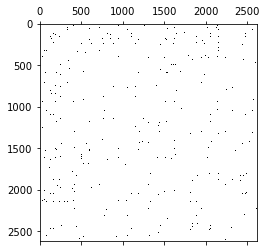

In [25]:
plt.spy(W)

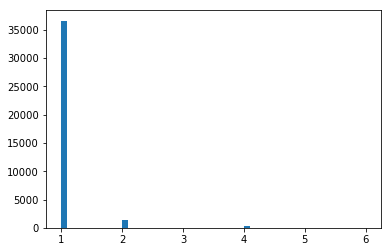

In [26]:
plt.hist(W[W > 0].reshape(-1), bins=50);

In [27]:
print('There are {} edges equal to zero '.format(np.sum(W == 0)/2))
print('There are {} edges equal to one '.format(np.sum(W == 1)/2))
print('There are {} edges equal to two '.format(np.sum(W == 2)))
print('There are {} edges equal to three '.format(np.sum(W == 3)))
print('There are {} edges equal to four '.format(np.sum(W == 4)))
print('There are {} edges equal to five '.format(np.sum(W == 5)/2))

There are 3415674.5 edges equal to zero 
There are 18309.0 edges equal to one 
There are 1324 edges equal to two 
There are 38 edges equal to three 
There are 288 edges equal to four 
There are 11.0 edges equal to five 


In [29]:
NotnormW = pd.DataFrame(W)
NotnormW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
NotnormW.to_csv('Saved_Datasets/NotNormActorW.csv', index=False)

In [31]:
NotnormW = pd.read_csv('Saved_Datasets/NotNormActorW.csv')
NotnormW = NotnormW.as_matrix()

### Weight matrix normalization ###

In [35]:
Wnorm2 = np.ndarray(shape=(len(dataset), len(dataset)), dtype=float)

for i in range(0, len(W)):
    for j in range(0, len(W)):
        if i!=j: 
            if W[i][j] > 3:
                Wnorm2[i][j] = 1
            else:
                Wnorm2[i][j] =  W[i][j]/3

#fill the diagonal values to zero, i.e. no self-connections
np.fill_diagonal(Wnorm2, 0)

In [51]:
Norm2W = pd.DataFrame(Wnorm2)
Norm2W.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
Norm2W.to_csv('Saved_Datasets/Normalized3ActorW.csv', index=False)

In [39]:
Norm2W = Norm2W.as_matrix()

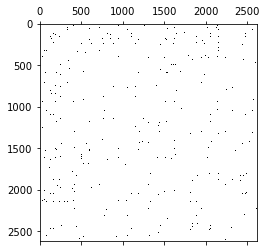

In [40]:
plt.spy(Norm2W)

In [41]:
laplacian_norm2 = scipy.sparse.csgraph.laplacian(Norm2W, normed = True)

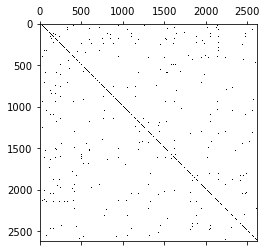

In [43]:
plt.spy(laplacian_norm2);